# CIFAR-10 SNN Benchmark: All Architectures

Trains and evaluates all five SNN architectures on CIFAR-10 under identical conditions.

**Models:**
1. Baseline LIF (control)
2. DASNN — Dendritic multi-branch neurons with heterogeneous time constants
3. Spiking-KAN — Chebyshev polynomial activations
4. NEXUS-SNN — Adaptive thresholds + ChebyKAN + skip connections
5. APEX-SNN — Parametric LIF + progressive sparsity + multi-scale readout
6. ANN Baseline (non-spiking reference)

**Protocol:**
- Same convolutional backbone (3 blocks, 64→128→256 channels)
- Adam optimizer, lr=1e-3, cosine annealing over 50 epochs
- 4 time steps for all SNN models
- Standard CIFAR-10 augmentation (random crop + horizontal flip)

**Metrics:** Test accuracy, spike rate, activation sparsity, parameter count, training time

In [ ]:
!pip install torch torchvision matplotlib numpy -q
!nvidia-smi

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import json

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


---
## 1. Core SNN Components

Surrogate gradient (ATan) and neuron models shared across all architectures.

In [3]:
# ── Surrogate Gradient ──────────────────────────────────────────────────────

class ATanSurrogate(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha=2.0):
        ctx.save_for_backward(x)
        ctx.alpha = alpha
        return (x >= 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors
        alpha = ctx.alpha
        grad = alpha / (2 * (1 + (np.pi / 2 * alpha * x) ** 2))
        return grad * grad_output, None

def spike_fn(x):
    return ATanSurrogate.apply(x, 2.0)


# ── Standard LIF Neuron ────────────────────────────────────────────────────

class LIFNeuron(nn.Module):
    """Leaky integrate-and-fire with soft reset."""
    def __init__(self, tau=2.0):
        super().__init__()
        self.beta = 1.0 - 1.0 / tau
        self.v = None

    def reset(self):
        self.v = None

    def forward(self, x):
        if self.v is None:
            self.v = torch.zeros_like(x)
        self.v = self.beta * self.v + (1 - self.beta) * x
        spike = spike_fn(self.v - 1.0)
        self.v = self.v - spike.detach()
        return spike


# ── Adaptive LIF (learnable threshold per channel) ─────────────────────────

class AdaptiveLIFNeuron(nn.Module):
    def __init__(self, channels, tau=2.0):
        super().__init__()
        self.beta = 1.0 - 1.0 / tau
        self.threshold = nn.Parameter(torch.ones(channels))
        self.v = None

    def reset(self):
        self.v = None

    def forward(self, x):
        if self.v is None:
            self.v = torch.zeros_like(x)
        self.v = self.beta * self.v + (1 - self.beta) * x
        thr = self.threshold.abs()
        if x.dim() == 4:
            thr = thr.view(1, -1, 1, 1)
        else:
            thr = thr.view(1, -1)
        spike = spike_fn(self.v - thr)
        self.v = self.v - spike.detach() * thr
        return spike


# ── Parametric LIF (learnable tau per channel) ─────────────────────────────

class ParametricLIFNeuron(nn.Module):
    def __init__(self, channels, tau_init=2.0):
        super().__init__()
        self.log_tau = nn.Parameter(torch.full((channels,), np.log(tau_init)))
        self.v = None

    def reset(self):
        self.v = None

    def forward(self, x):
        tau = torch.exp(self.log_tau).clamp(1.1, 20.0)
        beta = 1.0 - 1.0 / tau
        if x.dim() == 4:
            beta = beta.view(1, -1, 1, 1)
        else:
            beta = beta.view(1, -1)
        if self.v is None:
            self.v = torch.zeros_like(x)
        self.v = beta * self.v + (1 - beta) * x
        spike = spike_fn(self.v - 1.0)
        self.v = self.v - spike.detach()
        return spike

print('Neuron models ready.')

Neuron models ready.


## 2. Shared Modules

Chebyshev KAN activation and progressive sparsity layer, used by NEXUS and APEX.

In [4]:
class ChebyshevKAN(nn.Module):
    """Channel-wise Chebyshev polynomial transformation.
    Replaces fixed activations with learnable polynomials."""

    def __init__(self, channels, degree=3):
        super().__init__()
        self.degree = degree
        self.coefficients = nn.Parameter(torch.zeros(channels, degree + 1))
        nn.init.constant_(self.coefficients[:, 1], 1.0)
        nn.init.normal_(self.coefficients[:, 2:], 0, 0.01)
        self.residual_weight = nn.Parameter(torch.tensor(0.3))

    def forward(self, x):
        c = self.coefficients
        x_norm = torch.tanh(x * 0.3)
        T_prev = torch.ones_like(x_norm)
        T_curr = x_norm

        if x.dim() == 4:
            reshape = lambda v: v.view(1, -1, 1, 1)
        else:
            reshape = lambda v: v

        result = reshape(c[:, 0]) * T_prev
        if self.degree >= 1:
            result = result + reshape(c[:, 1]) * T_curr
        for i in range(2, self.degree + 1):
            T_next = 2 * x_norm * T_curr - T_prev
            result = result + reshape(c[:, i]) * T_next
            T_prev, T_curr = T_curr, T_next

        return result + self.residual_weight * x


class SparsityLayer(nn.Module):
    """Progressive sparsity: prunes a growing fraction of channels during training."""

    def __init__(self, channels, target_sparsity=0.7):
        super().__init__()
        self.importance = nn.Parameter(torch.ones(channels))
        self.target_sparsity = target_sparsity
        self.progress = 0.0

    def set_progress(self, progress):
        self.progress = progress

    def forward(self, x):
        importance = torch.sigmoid(self.importance)
        sparsity = 0.2 + self.progress * (self.target_sparsity - 0.2)
        if self.training:
            mask = importance
        else:
            threshold = torch.quantile(importance, sparsity)
            mask = (importance >= threshold).float()
        if x.dim() == 4:
            return x * mask.view(1, -1, 1, 1)
        return x * mask.view(1, -1)

print('Shared modules ready.')

Shared modules ready.


---
## 3. Model Definitions

All models share the same convolutional backbone shape:
- 3 conv blocks (64 → 128 → 256 channels), each with Conv2d(3×3) + BN + Spike + AvgPool(2)
- FC head: 4096 → 512 → 10

The difference is **which neuron type** and **which extra modules** each model uses.

### 3.1 Baseline LIF (Control)
Standard LIF neurons. No bells and whistles.

In [5]:
class BaselineSNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, tau=2.0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.lif1  = LIFNeuron(tau)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.lif2  = LIFNeuron(tau)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.lif3  = LIFNeuron(tau)

        self.pool = nn.AvgPool2d(2)
        self.fc1  = nn.Linear(256 * 4 * 4, 512)
        self.lif4 = LIFNeuron(tau)
        self.fc2  = nn.Linear(512, num_classes)

    def reset(self):
        for m in self.modules():
            if hasattr(m, 'reset') and m is not self:
                m.reset()

    def forward(self, x):
        spikes = []
        h = self.lif1(self.bn1(self.conv1(x))); spikes.append(h); h = self.pool(h)
        h = self.lif2(self.bn2(self.conv2(h))); spikes.append(h); h = self.pool(h)
        h = self.lif3(self.bn3(self.conv3(h))); spikes.append(h); h = self.pool(h)
        h = h.view(h.size(0), -1)
        h = self.lif4(self.fc1(h)); spikes.append(h)
        return self.fc2(h), spikes

print(f'BaselineSNN params: {sum(p.numel() for p in BaselineSNN().parameters()):,}')

BaselineSNN params: 2,474,506


### 3.2 DASNN — Dendritic Attention SNN

Each spiking neuron is replaced by a **multi-branch dendritic neuron**:
- 4 branches with different membrane time constants (τ ∈ [1.5, 8.0])
- Input-dependent gating selects which branch contributes at each spatial position
- The soma integrates the gated branches and fires if threshold is exceeded

In [6]:
class DendriticConvLIF(nn.Module):
    """Multi-branch conv LIF with heterogeneous time constants and gating."""
    def __init__(self, channels, num_branches=4, tau_range=(1.5, 8.0)):
        super().__init__()
        self.num_branches = num_branches
        taus = np.linspace(tau_range[0], tau_range[1], num_branches)
        self.register_buffer('betas', torch.tensor([1.0 - 1.0 / t for t in taus]))
        self.gate = nn.Conv2d(channels, num_branches, 1)
        self.branch_v = None

    def reset(self):
        self.branch_v = None

    def forward(self, x):
        if self.branch_v is None:
            self.branch_v = [torch.zeros_like(x) for _ in range(self.num_branches)]
        for i in range(self.num_branches):
            b = self.betas[i]
            self.branch_v[i] = b * self.branch_v[i] + (1 - b) * x
        gate = torch.softmax(self.gate(x), dim=1)          # [B, branches, H, W]
        soma = sum(gate[:, i:i+1] * self.branch_v[i]       # [B, 1, H, W] * [B, C, H, W]
                   for i in range(self.num_branches))
        spike = spike_fn(soma - 1.0)
        for i in range(self.num_branches):
            self.branch_v[i] = self.branch_v[i] - spike.detach()
        return spike


class DASNN_CIFAR(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, num_branches=4):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.lif1  = DendriticConvLIF(64, num_branches)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.lif2  = DendriticConvLIF(128, num_branches)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.lif3  = DendriticConvLIF(256, num_branches)

        self.pool = nn.AvgPool2d(2)
        self.fc1  = nn.Linear(256 * 4 * 4, 512)
        self.lif4 = LIFNeuron(2.0)
        self.fc2  = nn.Linear(512, num_classes)

    def reset(self):
        for m in self.modules():
            if hasattr(m, 'reset') and m is not self:
                m.reset()

    def forward(self, x):
        spikes = []
        h = self.lif1(self.bn1(self.conv1(x))); spikes.append(h); h = self.pool(h)
        h = self.lif2(self.bn2(self.conv2(h))); spikes.append(h); h = self.pool(h)
        h = self.lif3(self.bn3(self.conv3(h))); spikes.append(h); h = self.pool(h)
        h = h.view(h.size(0), -1)
        h = self.lif4(self.fc1(h)); spikes.append(h)
        return self.fc2(h), spikes

print(f'DASNN params: {sum(p.numel() for p in DASNN_CIFAR().parameters()):,}')

DASNN params: 2,476,310


### 3.3 Spiking-KAN

Inserts a **Chebyshev KAN activation** between batch norm and the LIF neuron in every layer.
The polynomial transformation gives each channel a learnable input-output curve before spiking.

In [7]:
class SpikingKAN_CIFAR(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, tau=2.0, degree=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.kan1  = ChebyshevKAN(64, degree)
        self.lif1  = LIFNeuron(tau)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.kan2  = ChebyshevKAN(128, degree)
        self.lif2  = LIFNeuron(tau)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.kan3  = ChebyshevKAN(256, degree)
        self.lif3  = LIFNeuron(tau)

        self.pool = nn.AvgPool2d(2)
        self.fc1  = nn.Linear(256 * 4 * 4, 512)
        self.lif4 = LIFNeuron(tau)
        self.fc2  = nn.Linear(512, num_classes)

    def reset(self):
        for m in self.modules():
            if hasattr(m, 'reset') and m is not self:
                m.reset()

    def forward(self, x):
        spikes = []
        h = self.lif1(self.kan1(self.bn1(self.conv1(x)))); spikes.append(h); h = self.pool(h)
        h = self.lif2(self.kan2(self.bn2(self.conv2(h)))); spikes.append(h); h = self.pool(h)
        h = self.lif3(self.kan3(self.bn3(self.conv3(h)))); spikes.append(h); h = self.pool(h)
        h = h.view(h.size(0), -1)
        h = self.lif4(self.fc1(h)); spikes.append(h)
        return self.fc2(h), spikes

print(f'SpikingKAN params: {sum(p.numel() for p in SpikingKAN_CIFAR().parameters()):,}')

SpikingKAN params: 2,476,301


### 3.4 NEXUS-SNN

Combines three ideas:
- **Adaptive LIF** neurons with per-channel learnable thresholds
- **ChebyKAN** activations for richer representations
- **Skip connection** from the first layer to the FC head

In [8]:
class NexusSNN_CIFAR(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, tau=2.0, degree=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.kan1  = ChebyshevKAN(64, degree)
        self.lif1  = AdaptiveLIFNeuron(64, tau)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.kan2  = ChebyshevKAN(128, degree)
        self.lif2  = AdaptiveLIFNeuron(128, tau)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.kan3  = ChebyshevKAN(256, degree)
        self.lif3  = AdaptiveLIFNeuron(256, tau)

        self.pool = nn.AvgPool2d(2)

        # Skip: global pool first-layer features → project to FC width
        self.skip = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(64, 512)
        )
        self.skip_weight = nn.Parameter(torch.tensor(0.2))

        self.fc1  = nn.Linear(256 * 4 * 4, 512)
        self.lif4 = AdaptiveLIFNeuron(512, tau)
        self.fc2  = nn.Linear(512, num_classes)

    def reset(self):
        for m in self.modules():
            if hasattr(m, 'reset') and m is not self:
                m.reset()

    def forward(self, x):
        spikes = []
        h = self.lif1(self.kan1(self.bn1(self.conv1(x)))); spikes.append(h)
        skip_h = h
        h = self.pool(h)
        h = self.lif2(self.kan2(self.bn2(self.conv2(h)))); spikes.append(h); h = self.pool(h)
        h = self.lif3(self.kan3(self.bn3(self.conv3(h)))); spikes.append(h); h = self.pool(h)
        h = h.view(h.size(0), -1)
        h = self.fc1(h) + self.skip_weight * self.skip(skip_h)
        h = self.lif4(h); spikes.append(h)
        return self.fc2(h), spikes

print(f'NEXUS-SNN params: {sum(p.numel() for p in NexusSNN_CIFAR().parameters()):,}')

NEXUS-SNN params: 2,510,542


### 3.5 APEX-SNN

Stacks everything:
- **Parametric LIF** — per-channel learnable time constant τ
- **ChebyKAN** activations
- **Progressive sparsity** — increasingly masks out channels during training
- **Multi-scale readout** — ensemble of classifiers attached at every layer depth

In [9]:
class ApexSNN_CIFAR(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, tau=2.0, degree=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.kan1  = ChebyshevKAN(64, degree)
        self.sp1   = SparsityLayer(64)
        self.lif1  = ParametricLIFNeuron(64, tau)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.kan2  = ChebyshevKAN(128, degree)
        self.sp2   = SparsityLayer(128)
        self.lif2  = ParametricLIFNeuron(128, tau)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.kan3  = ChebyshevKAN(256, degree)
        self.sp3   = SparsityLayer(256)
        self.lif3  = ParametricLIFNeuron(256, tau)

        self.pool = nn.AvgPool2d(2)

        self.fc1  = nn.Linear(256 * 4 * 4, 512)
        self.lif4 = ParametricLIFNeuron(512, tau)

        # Multi-scale readouts
        self.readout1  = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(64, num_classes))
        self.readout2  = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(128, num_classes))
        self.readout3  = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(256, num_classes))
        self.readout_fc = nn.Linear(512, num_classes)
        self.ensemble_w = nn.Parameter(torch.ones(4) / 4)

    def reset(self):
        for m in self.modules():
            if hasattr(m, 'reset') and m is not self:
                m.reset()

    def set_epoch(self, epoch, total_epochs):
        progress = epoch / (total_epochs + 1)
        for m in self.modules():
            if isinstance(m, SparsityLayer):
                m.set_progress(progress)

    def forward(self, x):
        spikes = []
        h = self.lif1(self.sp1(self.kan1(self.bn1(self.conv1(x))))); spikes.append(h)
        h1 = h; h = self.pool(h)
        h = self.lif2(self.sp2(self.kan2(self.bn2(self.conv2(h))))); spikes.append(h)
        h2 = h; h = self.pool(h)
        h = self.lif3(self.sp3(self.kan3(self.bn3(self.conv3(h))))); spikes.append(h)
        h3 = h; h = self.pool(h)
        h = h.view(h.size(0), -1)
        h = self.lif4(self.fc1(h)); spikes.append(h)

        w = F.softmax(self.ensemble_w, dim=0)
        out = (w[0] * self.readout1(h1) + w[1] * self.readout2(h2) +
               w[2] * self.readout3(h3) + w[3] * self.readout_fc(h))
        return out, spikes

print(f'APEX-SNN params: {sum(p.numel() for p in ApexSNN_CIFAR().parameters()):,}')

APEX-SNN params: 2,482,223


### 3.6 ANN Baseline (non-spiking)

Same convolutional backbone with ReLU instead of spiking neurons. Single forward pass (no time steps).

In [10]:
class ANN_Baseline(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.AvgPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.AvgPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.AvgPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512), nn.ReLU(), nn.Linear(512, num_classes)
        )

    def forward(self, x):
        h = self.features(x)
        return self.classifier(h.view(h.size(0), -1))

print(f'ANN params: {sum(p.numel() for p in ANN_Baseline().parameters()):,}')

ANN params: 2,474,506


---
## 4. Download & Load CIFAR-10

Download CIFAR-10 (~170 MB) and verify the dataset before training.

In [11]:
import os

os.makedirs('./data', exist_ok=True)

# ── Download CIFAR-10 ─────────────────────────────────────────────────────
print('Downloading CIFAR-10 (~170 MB)...')
raw_train = datasets.CIFAR10('./data', train=True,  download=True)
raw_test  = datasets.CIFAR10('./data', train=False, download=True)

CLASSES = raw_train.classes
print(f'\nCIFAR-10 downloaded successfully!')
print(f'  Train samples : {len(raw_train):,}')
print(f'  Test samples  : {len(raw_test):,}')
print(f'  Classes ({len(CLASSES)}): {CLASSES}')
print(f'  Image size    : {raw_train[0][0].size}')

# Verify downloaded files
data_dir = './data/cifar-10-batches-py'
if os.path.exists(data_dir):
    files = sorted(os.listdir(data_dir))
    total_size = sum(os.path.getsize(os.path.join(data_dir, f)) for f in files)
    print(f'\nFiles in {data_dir}/ ({total_size / 1e6:.1f} MB):')
    for f in files:
        size = os.path.getsize(os.path.join(data_dir, f))
        print(f'  {f:<25s} {size / 1e6:.1f} MB')

100%|██████████| 170M/170M [00:05<00:00, 31.3MB/s] 



CIFAR-10 downloaded successfully!
  Train samples : 50,000
  Test samples  : 10,000
  Classes (10): ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  Image size    : (32, 32)

Files in ./data/cifar-10-batches-py/ (186.2 MB):
  batches.meta              0.0 MB
  data_batch_1              31.0 MB
  data_batch_2              31.0 MB
  data_batch_3              31.0 MB
  data_batch_4              31.0 MB
  data_batch_5              31.0 MB
  readme.html               0.0 MB
  test_batch                31.0 MB


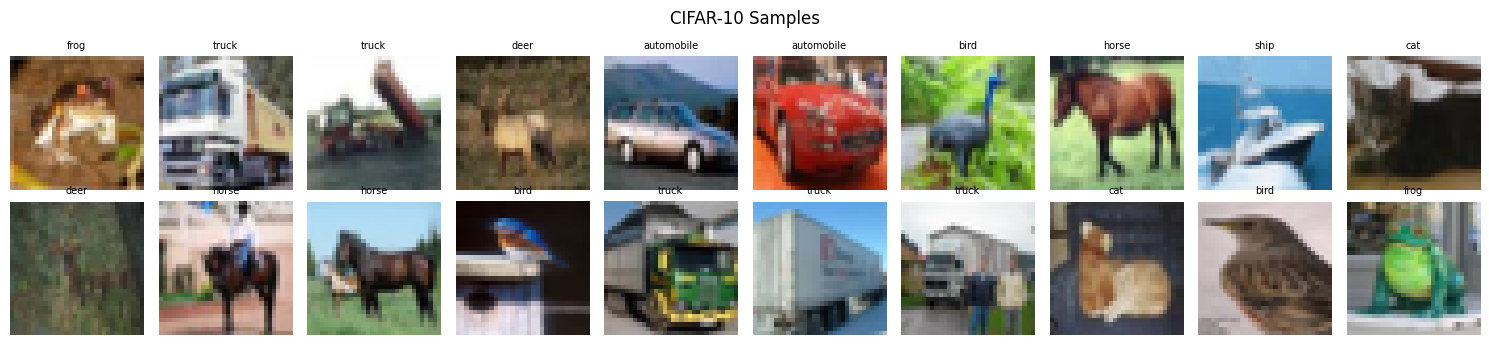

In [12]:
# ── Visualize samples ─────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 10, figsize=(15, 3.5))
for i in range(20):
    img, label = raw_train[i]
    ax = axes[i // 10, i % 10]
    ax.imshow(img)
    ax.set_title(CLASSES[label], fontsize=7)
    ax.axis('off')
plt.suptitle('CIFAR-10 Samples', fontsize=12)
plt.tight_layout()
plt.show()

del raw_train, raw_test  # free memory before creating augmented versions

In [13]:
# ── Build data loaders with augmentation ──────────────────────────────────

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data = datasets.CIFAR10('./data', train=True,  download=False, transform=train_transform)
test_data  = datasets.CIFAR10('./data', train=False, download=False, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# Verify a batch loads correctly
sample_batch, sample_labels = next(iter(train_loader))
print(f'Batch shape: {tuple(sample_batch.shape)}  (B, C, H, W)')
print(f'Label range: {sample_labels.min().item()} – {sample_labels.max().item()}')
print(f'Pixel range: [{sample_batch.min():.2f}, {sample_batch.max():.2f}]  (after normalization)')
print(f'\nTrain batches: {len(train_loader)}  |  Test batches: {len(test_loader)}')

Batch shape: (128, 3, 32, 32)  (B, C, H, W)
Label range: 0 – 9
Pixel range: [-2.43, 2.75]  (after normalization)

Train batches: 391  |  Test batches: 79


---
## 5. Training & Evaluation

In [14]:
# ── SNN training (multi-timestep) ──────────────────────────────────────────

def train_snn_epoch(model, loader, optimizer, device, timesteps=4):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        model.reset()
        outputs = []
        for t in range(timesteps):
            out, _ = model(data)
            outputs.append(out)
        logits = torch.stack(outputs).mean(0)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * target.size(0)
        correct += logits.argmax(1).eq(target).sum().item()
        total += target.size(0)
    return total_loss / total, 100.0 * correct / total


@torch.no_grad()
def eval_snn(model, loader, device, timesteps=4):
    model.eval()
    correct, total = 0, 0
    total_spikes, total_elements = 0.0, 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        model.reset()
        outputs = []
        for t in range(timesteps):
            out, spikes = model(data)
            outputs.append(out)
            for s in spikes:
                total_spikes += s.sum().item()
                total_elements += s.numel()
        logits = torch.stack(outputs).mean(0)
        correct += logits.argmax(1).eq(target).sum().item()
        total += target.size(0)
    accuracy = 100.0 * correct / total
    spike_rate = total_spikes / total_elements if total_elements > 0 else 0
    return accuracy, spike_rate


# ── ANN training (single pass) ────────────────────────────────────────────

def train_ann_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * target.size(0)
        correct += logits.argmax(1).eq(target).sum().item()
        total += target.size(0)
    return total_loss / total, 100.0 * correct / total


@torch.no_grad()
def eval_ann(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        logits = model(data)
        correct += logits.argmax(1).eq(target).sum().item()
        total += target.size(0)
    return 100.0 * correct / total

print('Training functions ready.')

Training functions ready.


---
## 6. Run Benchmark

Train all 6 models sequentially. Each gets 50 epochs with Adam + cosine annealing.

In [ ]:
EPOCHS    = 50
TIMESTEPS = 4
LR        = 1e-3

snn_configs = [
    ('Baseline LIF', BaselineSNN()),
    ('DASNN',        DASNN_CIFAR()),
    ('Spiking-KAN',  SpikingKAN_CIFAR()),
    ('NEXUS-SNN',    NexusSNN_CIFAR()),
    ('APEX-SNN',     ApexSNN_CIFAR()),
]

results = {}

for name, model in snn_configs:
    print(f'\n{"="*60}')
    print(f'  {name}')
    print(f'{"="*60}')
    model = model.to(device)
    params = sum(p.numel() for p in model.parameters())
    print(f'Parameters: {params:,}')

    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

    best_acc, best_spike = 0.0, 0.0
    history = {'train': [], 'test': [], 'spike': []}
    t0 = time.time()

    for epoch in range(EPOCHS):
        if hasattr(model, 'set_epoch'):
            model.set_epoch(epoch, EPOCHS)

        _, train_acc = train_snn_epoch(model, train_loader, optimizer, device, TIMESTEPS)
        test_acc, spike_rate = eval_snn(model, test_loader, device, TIMESTEPS)
        scheduler.step()

        history['train'].append(train_acc)
        history['test'].append(test_acc)
        history['spike'].append(spike_rate)

        if test_acc > best_acc:
            best_acc = test_acc
            best_spike = spike_rate

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'  Epoch {epoch+1:3d}/{EPOCHS} | '
                  f'Train {train_acc:.2f}% | Test {test_acc:.2f}% | '
                  f'Spike {spike_rate:.4f} | Best {best_acc:.2f}%')

    elapsed = time.time() - t0
    results[name] = dict(
        accuracy=best_acc, spike_rate=best_spike, sparsity=1-best_spike,
        parameters=params, timesteps=TIMESTEPS, time=elapsed, history=history,
    )
    print(f'\n  >> {name}: {best_acc:.2f}%  ({elapsed:.0f}s)')
    del model, optimizer, scheduler
    torch.cuda.empty_cache()

In [ ]:
# ── ANN Baseline ──────────────────────────────────────────────────────────
print(f'\n{"="*60}')
print(f'  ANN Baseline')
print(f'{"="*60}')

ann = ANN_Baseline().to(device)
ann_params = sum(p.numel() for p in ann.parameters())
print(f'Parameters: {ann_params:,}')

optimizer = optim.Adam(ann.parameters(), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

best_ann_acc = 0.0
ann_history = {'train': [], 'test': []}
t0 = time.time()

for epoch in range(EPOCHS):
    _, train_acc = train_ann_epoch(ann, train_loader, optimizer, device)
    test_acc = eval_ann(ann, test_loader, device)
    scheduler.step()
    ann_history['train'].append(train_acc)
    ann_history['test'].append(test_acc)
    if test_acc > best_ann_acc:
        best_ann_acc = test_acc
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'  Epoch {epoch+1:3d}/{EPOCHS} | '
              f'Train {train_acc:.2f}% | Test {test_acc:.2f}% | Best {best_ann_acc:.2f}%')

ann_elapsed = time.time() - t0
results['ANN Baseline'] = dict(
    accuracy=best_ann_acc, spike_rate=0, sparsity=0,
    parameters=ann_params, timesteps=1, time=ann_elapsed, history=ann_history,
)
print(f'\n  >> ANN Baseline: {best_ann_acc:.2f}%  ({ann_elapsed:.0f}s)')
del ann, optimizer, scheduler
torch.cuda.empty_cache()

---
## 7. Results

In [ ]:
print('\n' + '=' * 80)
print('CIFAR-10 BENCHMARK RESULTS')
print('=' * 80)
print(f'{"Model":<16} {"Accuracy":<11} {"Spike Rate":<12} {"Sparsity":<11} {"Params":<11} {"T":<4} {"Time":<8}')
print('-' * 80)

for name in ['Baseline LIF', 'DASNN', 'Spiking-KAN', 'NEXUS-SNN', 'APEX-SNN', 'ANN Baseline']:
    r = results[name]
    sr = f'{r["spike_rate"]:.4f}' if r['spike_rate'] > 0 else 'N/A'
    sp = f'{r["sparsity"]:.2f}'   if r['sparsity'] > 0 else 'N/A'
    print(f'{name:<16} {r["accuracy"]:.2f}%     {sr:<12} {sp:<11} {r["parameters"]:>9,}  {r["timesteps"]:<4} {r["time"]:.0f}s')

print('=' * 80)

# Gap analysis
ann_acc = results['ANN Baseline']['accuracy']
print(f'\nANN Baseline accuracy: {ann_acc:.2f}%')
for name in ['Baseline LIF', 'DASNN', 'Spiking-KAN', 'NEXUS-SNN', 'APEX-SNN']:
    gap = ann_acc - results[name]['accuracy']
    print(f'  {name:<16} gap: {gap:+.2f}%')

# Energy estimate
print(f'\nTheoretical energy (45nm CMOS, E_AC=0.9pJ, E_MAC=4.6pJ):')
for name in ['Baseline LIF', 'DASNN', 'Spiking-KAN', 'NEXUS-SNN', 'APEX-SNN']:
    sr = results[name]['spike_rate']
    ratio = sr * 0.9 / (0.5 * 4.6)  # vs 50% ReLU activation
    print(f'  {name:<16} energy ratio: {ratio:.3f}x  (saving: {(1-ratio)*100:.1f}%)')

In [ ]:
# ── Plots ─────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = {'Baseline LIF': '#1f77b4', 'DASNN': '#ff7f0e', 'Spiking-KAN': '#2ca02c',
          'NEXUS-SNN': '#d62728', 'APEX-SNN': '#9467bd', 'ANN Baseline': '#8c564b'}

# 1. Test accuracy curves
for name, r in results.items():
    axes[0].plot(r['history']['test'], label=name, color=colors[name], linewidth=1.5)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Learning Curves')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# 2. Accuracy bar chart
snn_names = ['Baseline LIF', 'DASNN', 'Spiking-KAN', 'NEXUS-SNN', 'APEX-SNN', 'ANN Baseline']
accs = [results[n]['accuracy'] for n in snn_names]
bar_colors = [colors[n] for n in snn_names]
bars = axes[1].bar(range(len(snn_names)), accs, color=bar_colors)
axes[1].set_xticks(range(len(snn_names)))
axes[1].set_xticklabels(snn_names, rotation=45, ha='right', fontsize=8)
axes[1].set_ylabel('Best Test Accuracy (%)')
axes[1].set_title('Final Accuracy Comparison')
for bar, acc in zip(bars, accs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{acc:.1f}', ha='center', fontsize=8)
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Spike rate over training (SNN only)
for name in ['Baseline LIF', 'DASNN', 'Spiking-KAN', 'NEXUS-SNN', 'APEX-SNN']:
    axes[2].plot(results[name]['history']['spike'], label=name, color=colors[name], linewidth=1.5)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Spike Rate')
axes[2].set_title('Spike Rate During Training')
axes[2].legend(fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cifar10_all_models.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ── Accuracy vs Spike Rate scatter ────────────────────────────────────────

fig, ax = plt.subplots(figsize=(8, 6))
for name in ['Baseline LIF', 'DASNN', 'Spiking-KAN', 'NEXUS-SNN', 'APEX-SNN']:
    r = results[name]
    ax.scatter(r['spike_rate'], r['accuracy'], s=r['parameters']/5000,
               color=colors[name], label=name, alpha=0.8, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Spike Rate (lower = more efficient)')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Accuracy vs Spike Rate (bubble size = parameter count)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cifar10_accuracy_vs_spike.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ── Save results ──────────────────────────────────────────────────────────

results_save = {
    name: {k: v for k, v in r.items() if k != 'history'}
    for name, r in results.items()
}
with open('cifar10_benchmark_results.json', 'w') as f:
    json.dump(results_save, f, indent=2)

print('Results saved to cifar10_benchmark_results.json')

# Optional: save to Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import shutil
    shutil.copy('cifar10_benchmark_results.json', '/content/drive/MyDrive/')
    shutil.copy('cifar10_all_models.png', '/content/drive/MyDrive/')
    shutil.copy('cifar10_accuracy_vs_spike.png', '/content/drive/MyDrive/')
    print('Saved to Google Drive.')
except Exception:
    print('Google Drive not available, results saved locally.')